In [69]:
import sys
sys.path.append("../")

from dotenv import load_dotenv
load_dotenv()
import geopandas as gpd
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import rasterio as rio
from rasterio.plot import show
import seaborn as sns
import shapely
import statsmodels.api as sm

from openbustools import plotting, spatial, standardfeeds

In [ ]:
# Starts with a shapefile of a route, and creates a drive cycle

# The shapefile comes from the GTFS, or from manually specified GPS points
# A drivecycle is a trajectory that can be put into energy model
# It must have time, distance and elevation at each point

# How is it used
# GTFS/GTFS-RT/Phone
# Aggregate GTFS-RT how? Go from many obs of points along path in time, to a single set of points
# Phone is same as single GTFS-RT trip but higher resolution

In [133]:
data_gtfsrt = pd.read_pickle("../data/kcm_realtime/processed/2023_03_19.pkl")

In [2]:
# GTFS shapes
shape_lookup = standardfeeds.get_gtfs_shapes_lookup("../data/kcm_gtfs/2023_05_14/")
shapes = standardfeeds.get_gtfs_shapes("../data/kcm_gtfs/2023_05_14/").to_crs("EPSG:32148")

In [3]:
# GTFS-RT
data_gtfsrt = pd.read_pickle("../data/kcm_realtime/2023_05_19.pkl")
data_gtfsrt['locationtime'] = pd.to_numeric(data_gtfsrt['locationtime'])
valid_service_ids = standardfeeds.date_to_service_id('2023_05_19', "../data/kcm_gtfs/2023_05_14/")
data_gtfsrt = data_gtfsrt.merge(shape_lookup, on='trip_id')
data_gtfsrt = gpd.GeoDataFrame(data_gtfsrt, geometry=gpd.points_from_xy(data_gtfsrt.lon, data_gtfsrt.lat), crs="EPSG:4326").to_crs("EPSG:32148")
data_gtfsrt['calc_time_s'], data_gtfsrt['calc_dist_m'] = spatial.calculate_gps_metrics(data_gtfsrt, 'locationtime')
data_gtfsrt = data_gtfsrt.drop(data_gtfsrt.groupby('trip_id', as_index=False).nth(0).index)
data_gtfsrt['calc_speed_m_s'] = data_gtfsrt['calc_dist_m'] / data_gtfsrt['calc_time_s']
data_gtfsrt.loc[data_gtfsrt['calc_speed_m_s']<.1, 'calc_speed_m_s'] = 0

# First/last few points of every trip tend to have outliers
data_gtfsrt = data_gtfsrt.drop(data_gtfsrt.groupby('trip_id', as_index=False).nth(0).index)
data_gtfsrt = data_gtfsrt.drop(data_gtfsrt.groupby('trip_id', as_index=False).nth(0).index)
data_gtfsrt = data_gtfsrt.drop(data_gtfsrt.groupby('trip_id', as_index=False).nth(0).index)
data_gtfsrt = data_gtfsrt.drop(data_gtfsrt.groupby('trip_id', as_index=False).nth(0).index)
data_gtfsrt = data_gtfsrt.drop(data_gtfsrt.groupby('trip_id', as_index=False).nth(-1).index)
data_gtfsrt = data_gtfsrt.drop(data_gtfsrt.groupby('trip_id', as_index=False).nth(-1).index)
data_gtfsrt = data_gtfsrt.drop(data_gtfsrt.groupby('trip_id', as_index=False).nth(-1).index)
data_gtfsrt = data_gtfsrt.drop(data_gtfsrt.groupby('trip_id', as_index=False).nth(-1).index)

# Filter out all trips with large outliers
mins_keep = 4
toss_speed_trip_ids = list(data_gtfsrt[data_gtfsrt['calc_speed_m_s']>30]['trip_id'])
toss_dist_trip_ids = list(data_gtfsrt[data_gtfsrt['calc_dist_m']>mins_keep*60*30]['trip_id'])
toss_time_trip_ids = list(data_gtfsrt[data_gtfsrt['calc_time_s']>mins_keep*60]['trip_id'])

toss_ids = []
toss_ids.extend(toss_speed_trip_ids)
toss_ids.extend(toss_dist_trip_ids)
toss_ids.extend(toss_time_trip_ids)
toss_ids = np.unique(toss_ids)
print(len(toss_ids) / len(np.unique(data_gtfsrt['trip_id'])))

print(len(data_gtfsrt))
data_gtfsrt = data_gtfsrt[~data_gtfsrt['trip_id'].isin(toss_ids)]
print(len(data_gtfsrt))

0.12536181255614331
723810
620146


In [51]:
# GTFS
data_calendar = pd.read_csv("../data/kcm_gtfs/2023_05_14/calendar.txt")
data_gtfs = standardfeeds.merge_gtfs_files("../data/kcm_gtfs/2023_05_14/", epsg="32148", coord_ref_center=[386910,69022])
data_gtfs = gpd.GeoDataFrame(data_gtfs, geometry=gpd.points_from_xy(data_gtfs.stop_lon, data_gtfs.stop_lat), crs="EPSG:4326").to_crs("EPSG:32148")
data_gtfs['calc_time_s'], data_gtfs['calc_dist_m'] = spatial.calculate_gps_metrics(data_gtfs, 'arrival_s')
data_gtfs = data_gtfs.drop(data_gtfs.groupby('trip_id', as_index=False).nth(0).index)
data_gtfs['calc_speed_m_s'] = data_gtfs['calc_dist_m'] / data_gtfs['calc_time_s']

In [5]:
# Get one shape to work with
sample_service_id, sample_route_id, sample_direction_id = data_gtfsrt.groupby(['service_id','route_id','direction_id']).count().index[42]

# GTFS-RT
sample_realtime = data_gtfsrt[(data_gtfsrt['service_id']==sample_service_id) & (data_gtfsrt['route_id']==sample_route_id) & (data_gtfsrt['direction_id']==sample_direction_id)].copy()

# GTFS
sample_static = data_gtfs[(data_gtfs['service_id']==sample_service_id) & (data_gtfs['route_id']==sample_route_id) & (data_gtfs['direction_id']==sample_direction_id)].copy()

# Shape
sample_shape = shapes[(shapes['service_id']==sample_service_id) & (shapes['route_id']==sample_route_id) & (shapes['direction_id']==sample_direction_id)].copy()

In [6]:
# Get distance along shape
sample_realtime['dist_along_line'] = sample_realtime['geometry'].apply(lambda pt: shapely.line_locate_point(sample_shape.geometry, pt))
sample_static['dist_along_line'] = sample_static['geometry'].apply(lambda pt: shapely.line_locate_point(sample_shape.geometry, pt))

# Also get a timestamp column on the samples
sample_realtime['t'] = pd.to_datetime(sample_realtime['locationtime'], unit='s')
sample_realtime = sample_realtime.set_index('t')

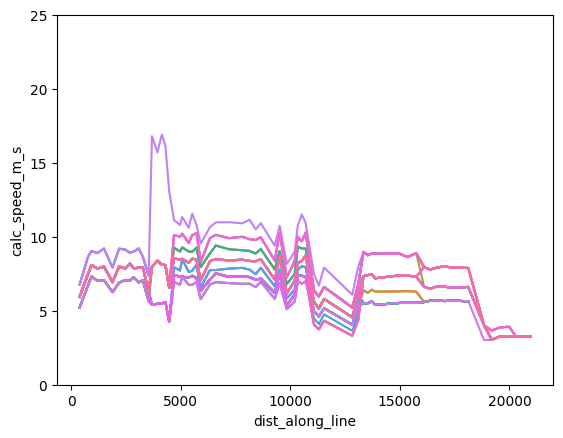

In [7]:
ax = sns.lineplot(sample_static, x='dist_along_line', y='calc_speed_m_s', hue='trip_id', legend=False).set_ylim(0,25)

(0.0, 25.0)

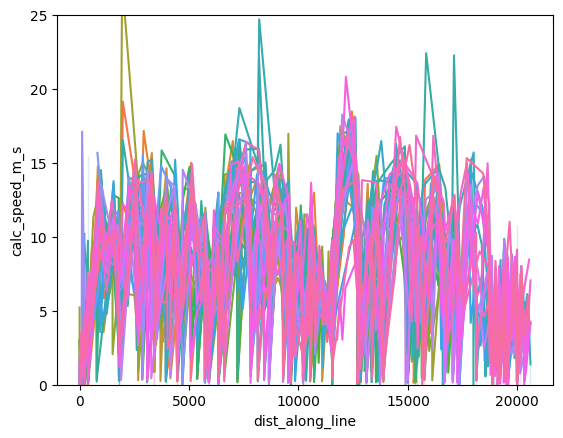

In [8]:
sns.lineplot(sample_realtime, x='dist_along_line', y='calc_speed_m_s', hue='trip_id', legend=False).set_ylim(0,25)

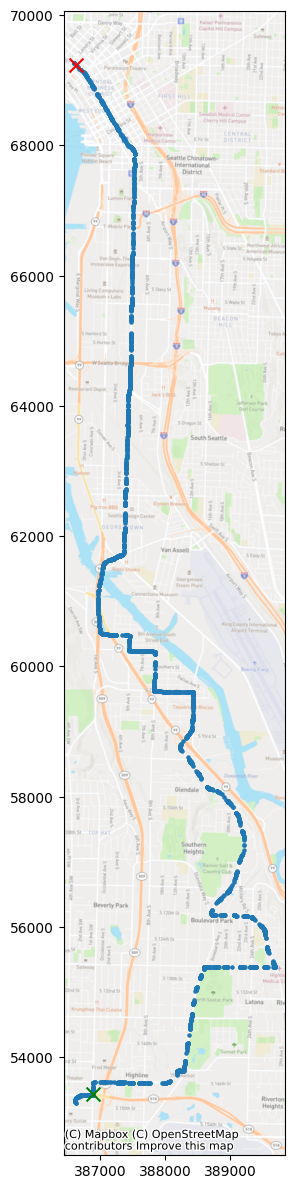

In [9]:
plotting.formatted_basemap_scatterplot(sample_realtime)

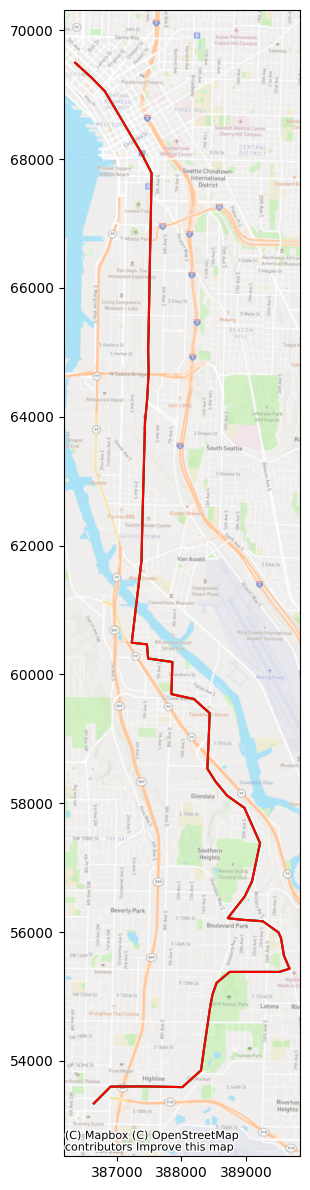

In [10]:
plotting.formatted_basemap_scatterplot(sample_shape)

/Users/zackaemmer/Desktop/open_bus_tools/obt_venv/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


<Axes: xlabel='dist_along_line', ylabel='calc_speed_m_s'>

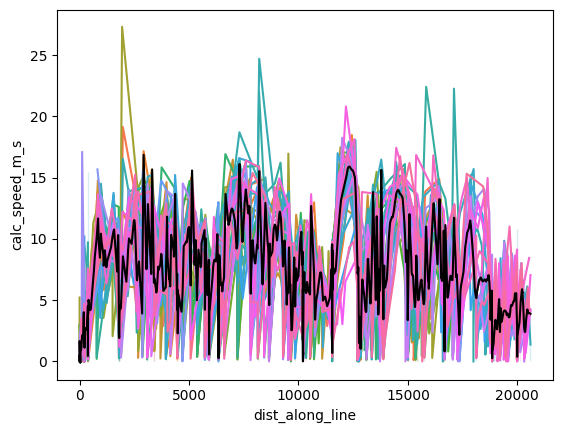

In [11]:
filtered = sm.nonparametric.lowess(endog=sample_realtime['calc_speed_m_s'], exog=sample_realtime['dist_along_line'], frac=0.01, it=1)
axes = sns.lineplot(sample_realtime, x='dist_along_line', y='calc_speed_m_s', hue='trip_id', legend=False)
sns.lineplot(x=filtered[:,0], y=filtered[:,1], ax=axes, color='black')

/Users/zackaemmer/Desktop/open_bus_tools/obt_venv/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:233: RuntimeWarning: invalid value encountered in divide
  _, weights = _lowess(y, x, x, np.ones_like(x),
/Users/zackaemmer/Desktop/open_bus_tools/obt_venv/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:240: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, xvalues, weights,


<Axes: xlabel='dist_along_line', ylabel='calc_speed_m_s'>

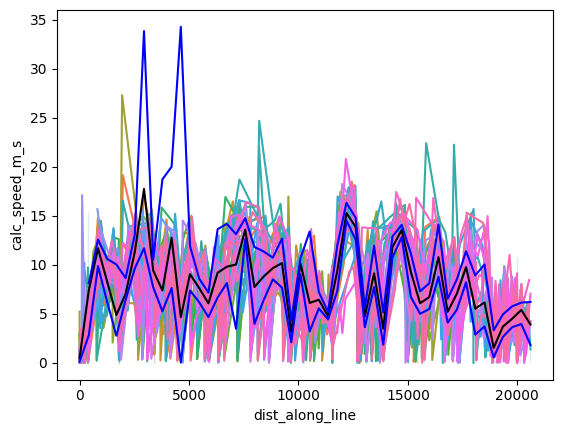

In [11]:
# Compute the 95% confidence interval
eval_x = np.linspace(0, max(sample_realtime['dist_along_line'].values))
smoothed, bottom, top = plotting.lowess_with_confidence_bounds(sample_realtime['dist_along_line'].values, sample_realtime['calc_speed_m_s'].values, eval_x, lowess_kw={"frac": 0.01})
axes = sns.lineplot(sample_realtime, x='dist_along_line', y='calc_speed_m_s', hue='trip_id', legend=False)
# axes.set_xlim(0,5000)
# axes.set_ylim(0,20)
sns.lineplot(x=eval_x, y=smoothed, color='black', ax=axes)
sns.lineplot(x=eval_x, y=top, color='blue', ax=axes)
sns.lineplot(x=eval_x, y=bottom, color='blue', ax=axes)

In [63]:
# Phone drive cycle in space
data_phone = pd.read_csv("../data/kcm_validation_sensor/8124-33-2022-10-17_20-52-26/Location.csv")
short_name, veh_id = str.split(pd.read_csv("../data/kcm_validation_sensor/8124-33-2022-10-17_20-52-26/Annotation.csv").iloc[0].text,"-")
data_phone = gpd.GeoDataFrame(data_phone, geometry=gpd.points_from_xy(data_phone.longitude, data_phone.latitude), crs="EPSG:4326").to_crs("EPSG:32148")
data_phone['calc_time_s'], data_phone['calc_dist_m'] = spatial.calculate_gps_metrics(data_phone, 'seconds_elapsed')
data_phone = data_phone.drop(index=0)
data_phone['calc_speed_m_s'] = data_phone['calc_dist_m'] / data_phone['calc_time_s']

route_ids = pd.unique(data_gtfs[(data_gtfs['route_short_name']==short_name) & (data_gtfs['direction_id']==0)].route_id)
phone_shape = shapes[(shapes['route_id'].isin(route_ids)) & (shapes['direction_id']==0) & (shapes['service_id']==21133)]

In [64]:
data_phone['dist_along_line'] = data_phone['geometry'].apply(lambda pt: shapely.line_locate_point(phone_shape.geometry, pt))


<Axes: >

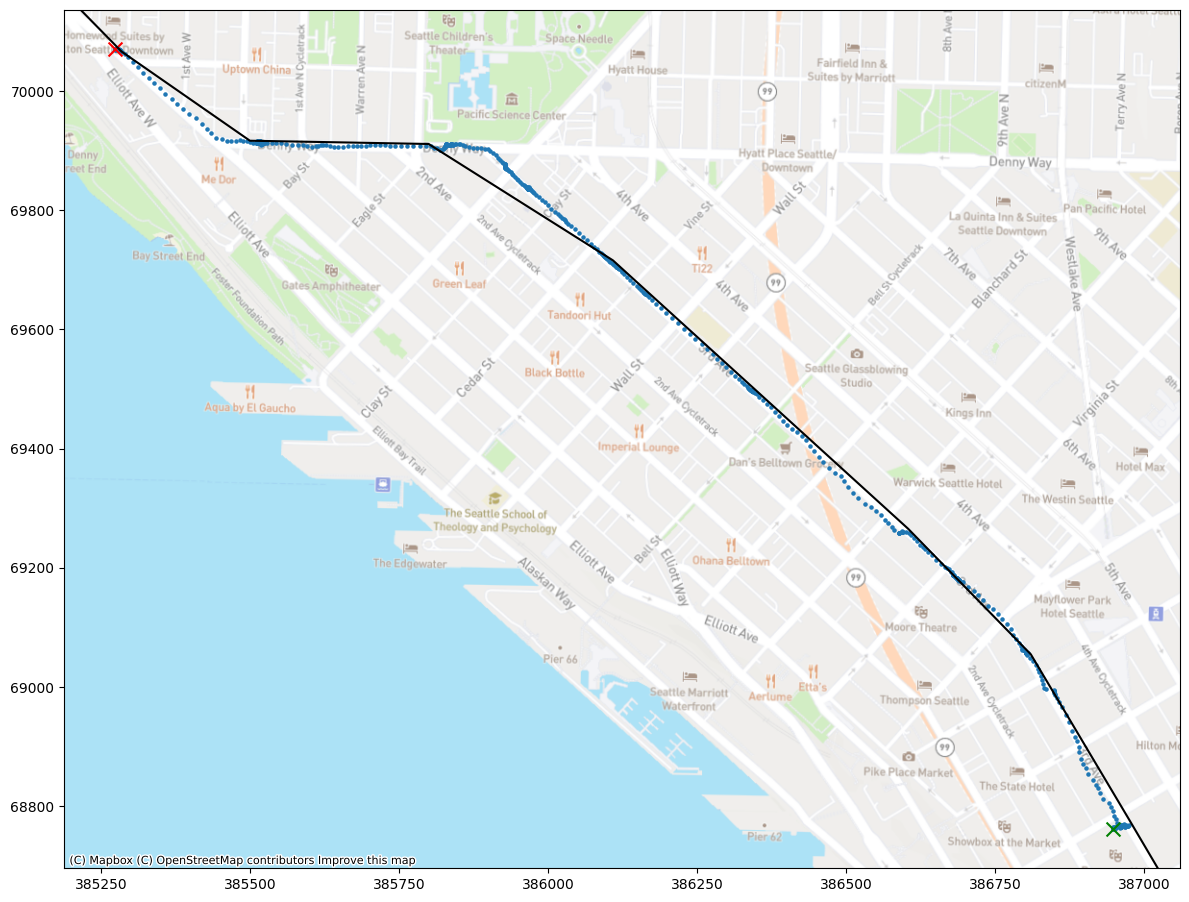

In [76]:
fig, axes = plotting.formatted_basemap_scatterplot(data_phone)
phone_shape.plot(ax=axes, color='black')

<Axes: xlabel='dist_along_line', ylabel='calc_speed_m_s'>

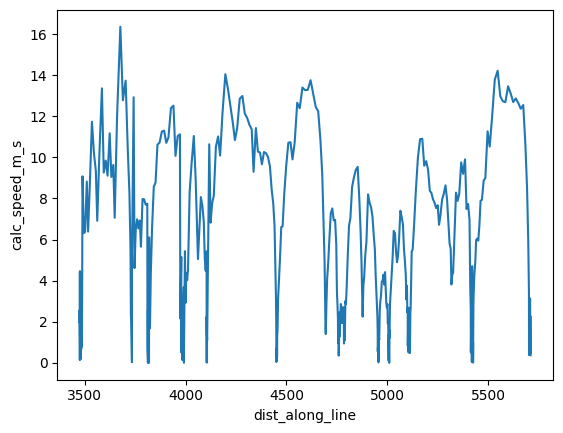

In [67]:
sns.lineplot(data_phone, x='dist_along_line', y='calc_speed_m_s')

### Trip GPS Points

In [ ]:
data_phone = pd.read_csv("../data/kcm_validation_sensor/8124-33-2022-10-17_20-52-26/Location.csv")
short_name, veh_id = str.split(pd.read_csv("../data/kcm_validation_sensor/8124-33-2022-10-17_20-52-26/Annotation.csv").iloc[0].text,"-")
data_phone = gpd.GeoDataFrame(data_phone, geometry=gpd.points_from_xy(data_phone.longitude, data_phone.latitude), crs="EPSG:4326").to_crs("EPSG:32148")
_, _, data_phone['calc_speed_m_s'] = spatial.calculate_speed(data_phone, 'seconds_elapsed')
plotting.formatted_basemap_scatterplot(data_phone, "Phone Basemap")

In [ ]:
data_gtfs = data_utils.merge_gtfs_files("../data/kcm_gtfs/2023_05_14/", epsg="32148", coord_ref_center=[386910,69022])
gtfs_calendar = pd.read_csv("../data/kcm_gtfs/2023_05_14/calendar.txt")
filtered_gtfs, remaining_trip_ids = data_utils.filter_gtfs_w_phone(data_phone, data_gtfs, short_name, gtfs_calendar)
filtered_gtfs = gpd.GeoDataFrame(filtered_gtfs, geometry=gpd.points_from_xy(filtered_gtfs.stop_lon, filtered_gtfs.stop_lat), crs="EPSG:4326").to_crs("EPSG:32148")
filtered_gtfs['seconds_elapsed'] = filtered_gtfs['arrival_s'] - filtered_gtfs['arrival_s'].iloc[0]
_, _, filtered_gtfs['calc_speed_m_s'] = spatial.calculate_speed(filtered_gtfs, 'seconds_elapsed')
plotting.formatted_basemap_scatterplot(filtered_gtfs, "GTFS Basemap")

In [ ]:
data_gtfsrt = pd.read_pickle("../data/kcm_realtime/2023_05_20.pkl")
data_gtfsrt['locationtime'] = pd.to_numeric(data_gtfsrt['locationtime'])
filtered_gtfsrt_daily = data_gtfsrt[data_gtfsrt['trip_id'].isin(remaining_trip_ids)]
filtered_gtfsrt_one = filtered_gtfsrt_daily[filtered_gtfsrt_daily['trip_id']==remaining_trip_ids[0]]
filtered_gtfsrt_one = gpd.GeoDataFrame(filtered_gtfsrt_one, geometry=gpd.points_from_xy(filtered_gtfsrt_one.lon, filtered_gtfsrt_one.lat), crs="EPSG:4326").to_crs("EPSG:32148")
filtered_gtfsrt_one['seconds_elapsed'] = filtered_gtfsrt_one['locationtime'] - filtered_gtfsrt_one['locationtime'].iloc[0]
_, _, filtered_gtfsrt_one['calc_speed_m_s'] = spatial.calculate_speed(filtered_gtfsrt_one, 'locationtime')
plotting.formatted_basemap_scatterplot(filtered_gtfsrt_one, "GTFS-RT Basemap One Trip")

In [ ]:
filtered_gtfsrt_daily = gpd.GeoDataFrame(filtered_gtfsrt_daily, geometry=gpd.points_from_xy(filtered_gtfsrt_daily.lon, filtered_gtfsrt_daily.lat), crs="EPSG:4326").to_crs("EPSG:32148")
filtered_gtfsrt_daily['seconds_elapsed'] = filtered_gtfsrt_daily['locationtime'] - filtered_gtfsrt_daily['locationtime'].iloc[0]
_, _, filtered_gtfsrt_daily['calc_speed_m_s'] = spatial.calculate_speed(filtered_gtfsrt_daily, 'locationtime')
plotting.formatted_basemap_scatterplot(filtered_gtfsrt_daily, "GTFS-RT Basemap Daily Trips")

### Drive Cycles

In [ ]:
data_melt_phone = pd.melt(data_phone, id_vars=['seconds_elapsed'], value_vars=['speed','calc_speed_m_s','altitudeAboveMeanSeaLevel'])
plotting.formatted_rel_lineplot(data_melt_phone, x_var='seconds_elapsed', y_var='value', rel_var='variable', title_text='Phone Speed')

In [ ]:
filtered_melt_gtfs = pd.melt(filtered_gtfs, id_vars=['seconds_elapsed'], value_vars=['calc_speed_m_s'])
plotting.formatted_rel_lineplot(filtered_melt_gtfs, x_var='seconds_elapsed', y_var='value', rel_var='variable', title_text='GTFS Speed', xlim=(0,2000), ylim=(0,35))

In [ ]:
filtered_melt_gtfsrt_one = pd.melt(filtered_gtfsrt_one, id_vars=['seconds_elapsed'], value_vars=['calc_speed_m_s'])
plotting.formatted_rel_lineplot(filtered_melt_gtfsrt_one, x_var='seconds_elapsed', y_var='value', rel_var='variable', title_text='GTFS-RT Drive Cycle One Trip', xlim=(0,2000), ylim=(0,35))

In [ ]:
filtered_melt_gtfsrt_daily = pd.melt(filtered_gtfsrt_daily, id_vars=['seconds_elapsed'], value_vars=['calc_speed_m_s'])
plotting.formatted_rel_lineplot(filtered_melt_gtfsrt_daily, x_var='seconds_elapsed', y_var='value', rel_var='variable', title_text='GTFS-RT Drive Cycle Daily Trips')